In [57]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
import reducing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [58]:
# Loading in all data to pd dataframes
property2016_raw = pd.read_csv("./Zillow-Data/properties_2016.csv",low_memory = False)
property2017_raw = pd.read_csv("./Zillow-Data/properties_2017.csv",low_memory = False)
train2016_raw = pd.read_csv("./Zillow-Data/train_2016_v2.csv")
train2017_raw = pd.read_csv("./Zillow-Data/train_2017.csv")

"""
reducing the size of the data stored with some brilliant code from:
originally by Kirgsn on kaggle: https://www.kaggle.com/code/wkirgsn/fail-safe-parallel-memory-reduction/comments
which was refined by Etienne Tremblay: https://www.kaggle.com/code/etremblay/fail-safe-parallel-memory-reduction/notebook

As this code doesn't directly apply to the semester project and is just an ease of life item for cleaning up and making 
the raw dataframes smaller and easier to manage I felt it was fine to include, however just note that this project would 
function identically if this code was removed.
"""
property2016 = reducing.Reducer().reduce(property2016_raw)
property2017 = reducing.Reducer().reduce(property2017_raw)
train2016 = reducing.Reducer().reduce(train2016_raw)
train2017 = reducing.Reducer().reduce(train2017_raw)

reduced df from 1320.9732 MB to 669.0274 MB in 6.45 seconds


reduced df from 1320.9732 MB to 669.0274 MB in 5.61 seconds


reduced df from 2.0664 MB to 0.8637 MB in 0.13 seconds


reduced df from 1.7765 MB to 0.7423 MB in 0.12 seconds


There look to be a lot of null values so This will look into which columns have the most

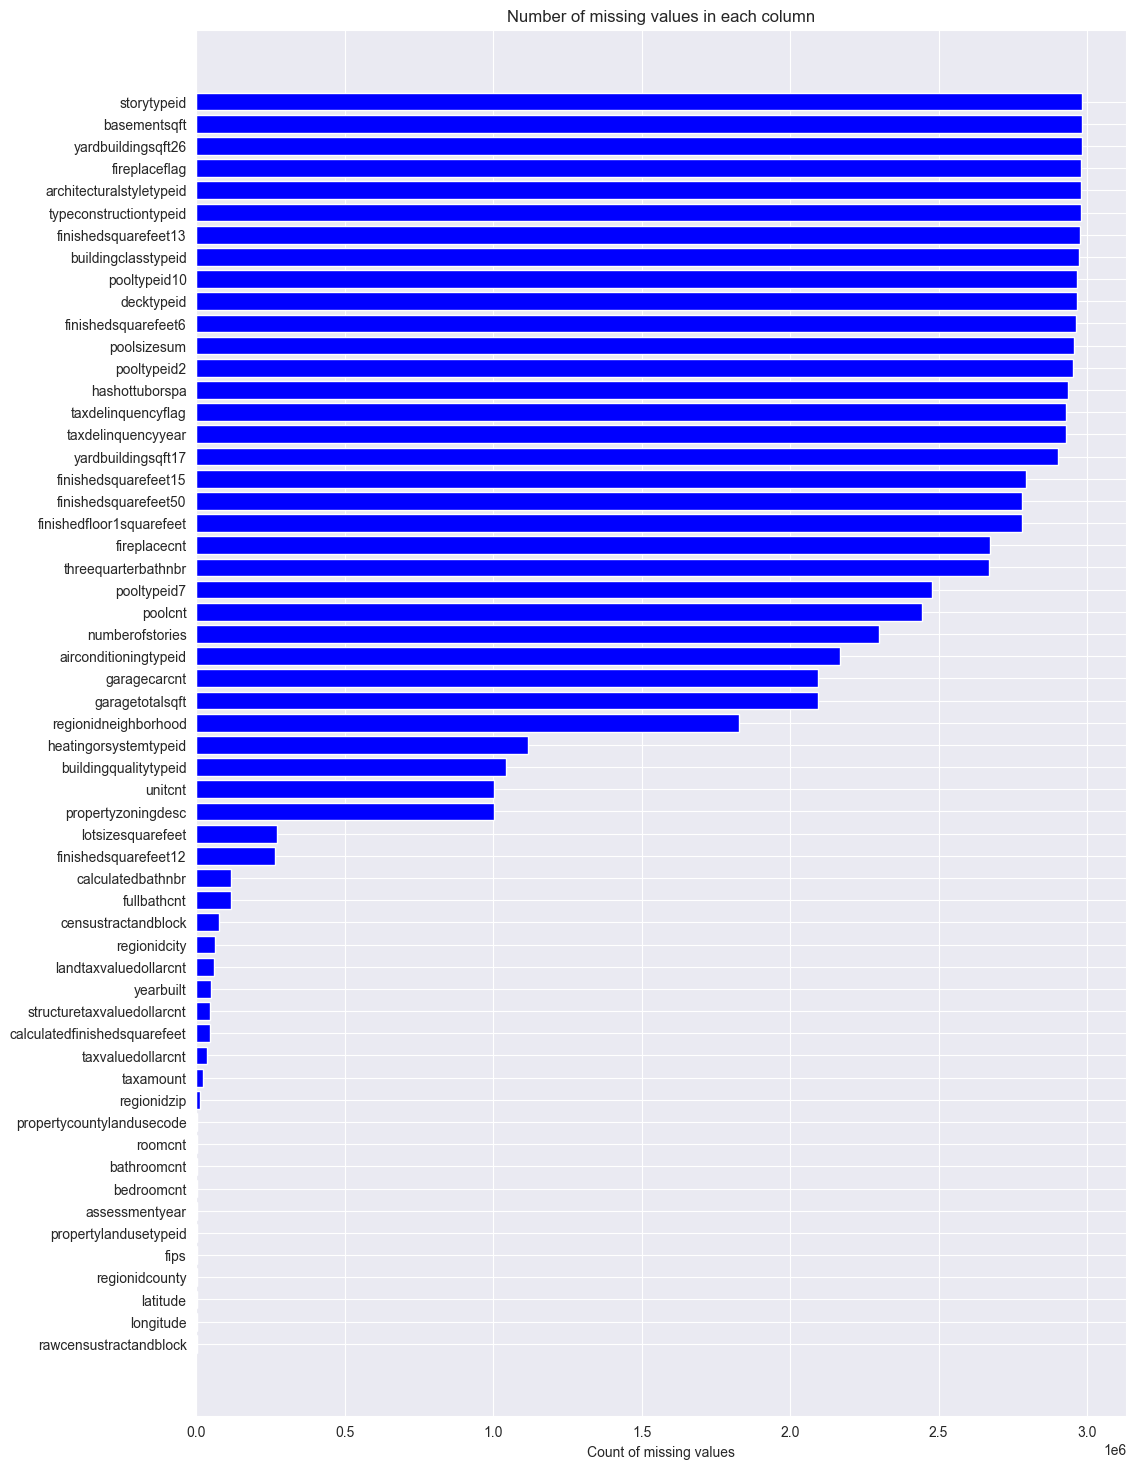

In [59]:
"""
Code for displaying the number of missing values taken from 
https://github.com/ojasphansekar/Zillow-Home-Value-Prediction/blob/master/Project.ipynb

Again, this code doesn't directly apply to the semester project of creating a machine learning model 
and is just an ease of life item for visualizing the number of Null values in each column I felt it was fine to include, 
however just note that this project would function identically if this code was removed.
"""
missing_df = property2017.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### Original testing code to make sure the model works

"""
If a column has more than 50% of the values missing it gets removed from the utilized columns
"""
NULL_CUTOFF_VALUE = 0.5
missing_df['missing_pct'] = missing_df['missing_count'] / property2017.shape[0]
good_features = missing_df[missing_df['missing_pct'] < NULL_CUTOFF_VALUE]

if 'parcelid' not in good_features['column_name'].values:
    good_features = pd.concat([good_features, pd.DataFrame([['parcelid', 0, 0]],columns=['column_name', 'missing_count', 'missing_pct'])],ignore_index=True)

property2017_subset = property2017[good_features['column_name']]

train_df = pd.merge(train2017, property2017_subset, on='parcelid', how='left')


train_df['propertyzoningdesc'], zoning_labels = pd.factorize(train_df['propertyzoningdesc'])

train_df['propertycountylandusecode'], land_use_labels = pd.factorize(train_df['propertycountylandusecode'])


In [60]:
# def prepare_data(train_data, property_data, missing_data, null_cutoff=0.5):
# 
#     missing_data['missing_pct'] = missing_data['missing_count'] / property_data.shape[0]
#     good_features = missing_data[missing_data['missing_pct'] < null_cutoff]
# 
#     if 'parcelid' not in good_features['column_name'].values:
#         good_features = pd.concat([good_features, pd.DataFrame([['parcelid', 0, 0]],
#                                                                columns=['column_name', 'missing_count',
#                                                                         'missing_pct'])], ignore_index=True)
# 
#     property_data_subset = property_data[good_features['column_name']]
# 
#     columns_to_drop = ['propertyzoningdesc', 'propertycountylandusecode']
#     for column in columns_to_drop:
#         property_data_subset = property_data_subset.drop(column, errors='ignore')
#         train_data = train_data.drop(column, errors='ignore')
# 
#     result_df = pd.merge(train_data, property_data_subset, on='parcelid', how='left')
# 
#     return result_df
# 
# missing_data2016 = property2016.isnull().sum().reset_index().rename(
#     columns={'index': 'column_name', 0: 'missing_count'})
# missing_data2017 = property2017.isnull().sum().reset_index().rename(
#     columns={'index': 'column_name', 0: 'missing_count'})
# 
# # Use your 'prepare_data' function
# train2016 = prepare_data(train2016, property2016, missing_data2016)
# train2017 = prepare_data(train2017, property2017, missing_data2017)

# Combine into one giant df
# train_df = pd.concat([train2016, train2017], axis = 0)
train_df = pd.merge(train2016, property2016, on='parcelid', how='left')

In [61]:
# train_df.dropna(inplace=True)

In [62]:
print(train_df.shape)

(90275, 60)


In [63]:
print(train_df.dtypes)

parcelid                          uint32
logerror                         float32
transactiondate                 category
airconditioningtypeid              UInt8
architecturalstyletypeid           UInt8
basementsqft                      UInt16
bathroomcnt                      float64
bedroomcnt                         UInt8
buildingclasstypeid                UInt8
buildingqualitytypeid              UInt8
calculatedbathnbr                float64
decktypeid                         UInt8
finishedfloor1squarefeet          UInt16
calculatedfinishedsquarefeet      UInt32
finishedsquarefeet12              UInt32
finishedsquarefeet13              UInt16
finishedsquarefeet15              UInt32
finishedsquarefeet50              UInt16
finishedsquarefeet6               UInt32
fips                              UInt16
fireplacecnt                       UInt8
fullbathcnt                        UInt8
garagecarcnt                       UInt8
garagetotalsqft                   UInt16
hashottuborspa  

In [64]:
non_numeric_columns = train_df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

Index(['transactiondate', 'hashottuborspa', 'propertycountylandusecode',
       'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag'],
      dtype='object')


In [65]:
train_df.drop(['transactiondate', 'hashottuborspa', 'propertycountylandusecode',
               'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag'],axis=1, inplace=True)

In [66]:
# corr_matrix = train_df.corr()
# 
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# 
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
# 
# sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
# 
# plt.show()

In [67]:
# correlation = train_df.corr()['logerror'].sort_values(ascending=False)
# print(correlation)

### Initial Thoughts and Findings

there is some initial correlation however no one item is really enough. Now it's time to split the data into what's needed 

In [68]:
X = train_df.drop([ 'logerror'], axis=1) # getting rid of some other weird items.
y = train_df['logerror'].values
print(X.shape, y.shape)

(90275, 53) (90275,)


In [69]:
# saving the cleaned file for future work:
train_df.to_csv("Zillow-Cleaned.csv", index=False)

### Deciding on a Model

I looked around on the competition website to see what other entries were using and it looks like most settled on a Gradient Boosting Machine for their model. This encouraged me to try three different methods. I want to try just a standard Random forest regressor, an XGBoost

In [70]:
non_numeric_columns = train_df.select_dtypes(exclude=[np.number]).columns
print(non_numeric_columns)

Index([], dtype='object')


In [71]:
print(X.dtypes)

parcelid                         uint32
airconditioningtypeid             UInt8
architecturalstyletypeid          UInt8
basementsqft                     UInt16
bathroomcnt                     float64
bedroomcnt                        UInt8
buildingclasstypeid               UInt8
buildingqualitytypeid             UInt8
calculatedbathnbr               float64
decktypeid                        UInt8
finishedfloor1squarefeet         UInt16
calculatedfinishedsquarefeet     UInt32
finishedsquarefeet12             UInt32
finishedsquarefeet13             UInt16
finishedsquarefeet15             UInt32
finishedsquarefeet50             UInt16
finishedsquarefeet6              UInt32
fips                             UInt16
fireplacecnt                      UInt8
fullbathcnt                       UInt8
garagecarcnt                      UInt8
garagetotalsqft                  UInt16
heatingorsystemtypeid             UInt8
latitude                         UInt32
longitude                         Int32


In [73]:
# Splitting the data into training and testing sets
# Assuming 'parcelid' is in the DataFrame 'train_df' and you've already prepared 'X' without 'parcelid'
split = 80000
x_train, y_train, x_valid, y_valid = X[:split], y[:split], X[split:], y[split:]

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_regressor.fit(x_train, y_train)

y_pred = rf_regressor.predict(x_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(mae, rmse) 

0.07324238376396798 0.15472483636904294


In [75]:
# TODO: DO NOT TOUCH THE CODE BELOW, IT WORKS, I DON'T KNOW WHY
sample = pd.read_csv('./Zillow-Data/sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
test_df = sample.merge(property2017, on='parcelid', how='left')
test_X = test_df[X.columns]
y_pred = rf_regressor.predict(test_X)
sub = pd.read_csv('./Zillow-Data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_pred

print('Writing csv ...')
sub.to_csv('submission5.csv', index=False, float_format='%.4f')

Writing csv ...
